In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Learnable parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
import seaborn as sns
import pandas as pd 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

In [2]:
n_points = 100
k = 2
x = np.linspace(0, 10, n_points)
y = .3*x+2*np.sin(x/1.5) + (.2+.02* ((x-5)*k)**2) * np.random.randn(n_points)

Text(0, 0.5, 'y')

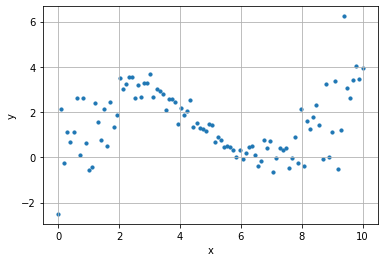

In [15]:
plt.scatter(x, y, s=10)
plt.grid();
plt.xlabel("x"); plt.ylabel("y")

In [16]:
inp  = tf.keras.layers.Input(shape=(1,))
out  = tf.keras.layers.Dense(10, activation="tanh")(inp)
out  = tf.keras.layers.Dense(10, activation="tanh")(out)
out  = tf.keras.layers.Dense(2)(out)
out  = tfp.layers.IndependentNormal()(out)

m    = tf.keras.models.Model(inp, out)

In [17]:
m.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_6 (Dense)             (None, 10)                20        
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 2)                 22        
                                                                 
 independent_normal_2 (Indep  ((None,),                0         
 endentNormal)                (None,))                           
                                                                 
Total params: 152
Trainable params: 152
Non-trainable params: 0
_____________________________________________________________

In [18]:
negloglik = lambda x, distribution: -distribution.log_prob(x)
m.compile(optimizer='adam', loss=negloglik)

In [19]:
history = m.fit(x,y, epochs=2000, verbose=0)

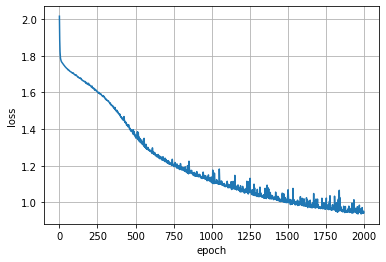

In [20]:
plt.plot(history.epoch, history.history['loss'])
plt.grid(); plt.xlabel("epoch"); plt.ylabel("loss");

get the predictive distributions for each input data point

In [21]:
_y = m(x)
_y

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[100] event_shape=[] dtype=float32>

observe the parameters learn for each datapoint

In [22]:
_x = np.r_[2]
_x

array([2])

In [23]:
loc = _y.parameters['distribution'].parameters['loc'].numpy()
scale = _y.parameters['distribution'].parameters['scale'].numpy()

Text(0, 0.5, 'y')

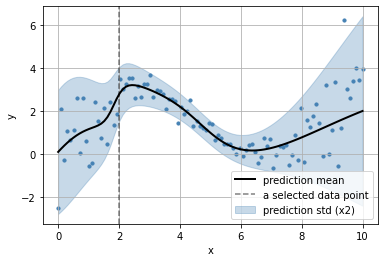

In [24]:
plt.scatter(x, y, s=10, color="steelblue")
plt.plot(x, loc, color="black", lw=2, label="prediction mean")
plt.fill_between(x, 
                 loc + 2*scale, 
                 loc - 2*scale, alpha=.3, 
                 color="steelblue",
                 label="prediction std (x2)")
plt.axvline(_x[0], color="black", ls="--", alpha=.5, label="a selected data point")
plt.grid(); plt.legend();
plt.xlabel("x"); plt.ylabel("y")

we can also see how it generalizes outside the input variable bounds


In [33]:
xr = np.linspace(np.min(x)-10, np.max(x)+10, 100)
yr = m(xr)

Text(0, 0.5, 'y')

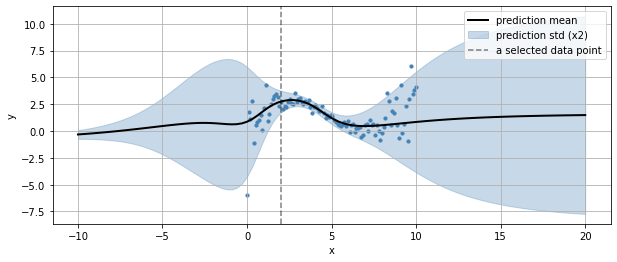

In [34]:
loc = yr.parameters['distribution'].parameters['loc'].numpy()
scale = yr.parameters['distribution'].parameters['scale'].numpy()

plt.figure(figsize=(10,4))
plt.scatter(x, y, s=10, color="steelblue")
plt.plot(xr, loc, color="black", lw=2, label="prediction mean")
plt.fill_between(xr, 
                 loc + 2*scale, 
                 loc - 2*scale, alpha=.3, 
                 color="steelblue",
                 label="prediction std (x2)")
plt.axvline(_x[0], color="black", ls="--", alpha=.5, label="a selected data point")
plt.grid(); plt.legend();
plt.xlabel("x"); plt.ylabel("y")

we can get the **predictive distribution** of any input data point (such as the selected one above)

In [35]:
_xd = m(_x)
_xd

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>

Text(0.5, 0, 'y distribution for x=2')

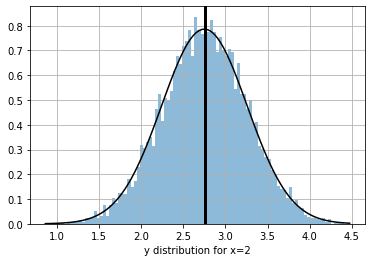

In [36]:
_ys = _xd.sample(10000)[:,0].numpy()
_yr = np.linspace(np.min(_ys), np.max(_ys), 100)
plt.plot(_yr, np.exp(_xd.log_prob(_yr)), color="black", alpha=1)
plt.hist(_ys, bins=100, density=True,  alpha=.5);
plt.axvline(_ys.mean(), color="black", lw=3)
plt.grid(); plt.xlabel(f"y distribution for x={_x[0]}")

and, since we have distributions we also have a generative model using the `.predict` method for sampling.

In [53]:
_x = np.random.random(1000)*(np.max(x)-np.min(x)) + np.min(x)
_y = m.predict(_x)

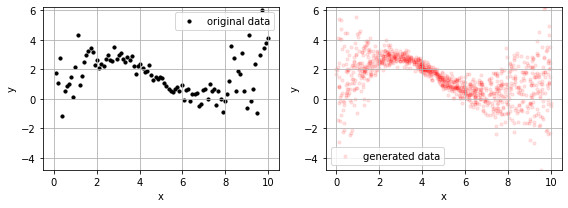

In [54]:
for ax,i in subplots(2, usizex=4):
    if i==1: plt.scatter(_x, _y, s=10, alpha=.1, color="red",  label="generated data");
    if i==0: plt.scatter(x, y, s=10, alpha=1, color="black", label="original data")
    plt.grid(); plt.legend();
    plt.xlabel("x"); plt.ylabel("y")
    plt.ylim(np.min(_y), np.max(_y))
plt.tight_layout()